In [1]:
import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from wrangle import wrangle_311

spark = pyspark.sql.SparkSession.builder.getOrCreate()

df = wrangle_311(spark)
print("\ndf shape: (%d, %d)\n" % (df.count(), len(df.columns)))
df.show(1, vertical=True)

[wrangle.py] reading case.csv
[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features
[wrangle.py] joining departments

df shape: (841704, 20)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                

## How many different cases are there, by department?

In [2]:
(
df.groupBy('department')
    .count()
    .show()
)
# those are all the cases by dept, trying to get distinct cases

+--------------------+------+
|          department| count|
+--------------------+------+
|         Solid Waste|279270|
|Animal Care Services|116915|
|Trans & Cap Impro...| 96193|
|  Parks & Recreation| 19907|
|    Customer Service|  2849|
|        Metro Health|  5163|
|        City Council|    33|
|DSD/Code Enforcement|321374|
+--------------------+------+



In [3]:
df.createOrReplaceTempView('df')

In [4]:
spark.sql('''
SELECT department, COUNT(DISTINCT(df.service_request_type)) as Different_case_types
FROM df
GROUP BY department
''').show()

+--------------------+--------------------+
|          department|Different_case_types|
+--------------------+--------------------+
|         Solid Waste|                  56|
|Animal Care Services|                  14|
|Trans & Cap Impro...|                  81|
|  Parks & Recreation|                  44|
|    Customer Service|                   2|
|        Metro Health|                  14|
|        City Council|                   2|
|DSD/Code Enforcement|                 122|
+--------------------+--------------------+



## Does the percentage of cases that are late vary by department?

- compare this to ravinder

In [5]:
(
df.withColumn("case_closed",df.case_closed.cast('int'))
    # note how we check the ouput of just this code to make sure before proceeding
.groupBy('department')
    .agg(mean('case_closed'))
#     .orderBy("true")
.show(vertical=True)
)

-RECORD 0--------------------------------
 department       | Solid Waste          
 avg(case_closed) | 0.9942349697425431   
-RECORD 1--------------------------------
 department       | Animal Care Services 
 avg(case_closed) | 0.9959885386819485   
-RECORD 2--------------------------------
 department       | Trans & Cap Impro... 
 avg(case_closed) | 0.9768070441716133   
-RECORD 3--------------------------------
 department       | Parks & Recreation   
 avg(case_closed) | 0.980107499874416    
-RECORD 4--------------------------------
 department       | Customer Service     
 avg(case_closed) | 0.5910845910845911   
-RECORD 5--------------------------------
 department       | Metro Health         
 avg(case_closed) | 0.9854735618826264   
-RECORD 6--------------------------------
 department       | City Council         
 avg(case_closed) | 0.12121212121212122  
-RECORD 7--------------------------------
 department       | DSD/Code Enforcement 
 avg(case_closed) | 0.962240255901

In [54]:
answer2 = (
df.withColumn("case_late",df.case_closed.cast('int'))
    # note how we check the ouput of just this code to make sure before proceeding
.groupBy('department')
    .agg(mean('case_late').alias('percent_case_late'))
#     .orderBy("true")
.toPandas()
)

In [55]:
answer2.set_index('department')

,percent_case_late
department,
Solid Waste,0.994235
Animal Care Services,0.995989
Trans & Cap Improvements,0.976807
Parks & Recreation,0.980107
Customer Service,0.591085
Metro Health,0.985474
City Council,0.121212
DSD/Code Enforcement,0.962240


Text(0.5, 1.0, 'Percent Case Closed By Department')

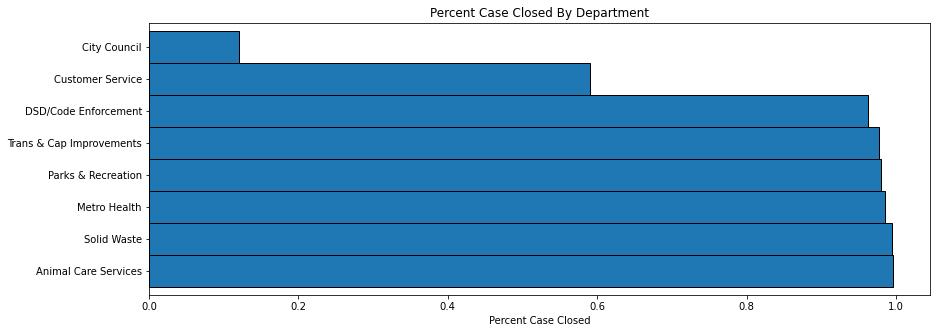

In [57]:
(
answer2.set_index("department")
    .percent_case_late.sort_values(ascending=False)
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5))
)

plt.xlabel("Percent Case Closed")
plt.ylabel("")
plt.title("Percent Case Closed By Department")


## On average, how late are the late cases by department?

In [9]:
# (
# df.where("case_late")
#     # note how we check the ouput of just this code to make sure before proceeding
# .groupBy('department')
#     .agg(mean('num_days_late'))
# #     .orderBy("true")
# .show(vertical=True)
# )

answer3 = (
df.where("case_late")
    # note how we check the ouput of just this code to make sure before proceeding
.groupBy('department')
    .agg(mean('num_days_late').alias('mean_days_late'))
    .toPandas()
# .show(vertical=True)
)

In [10]:
answer3

,department,mean_days_late
0,Solid Waste,7.186822
1,Animal Care Services,23.458633
2,Trans & Cap Improvements,10.603065
3,Parks & Recreation,22.348910
4,Customer Service,87.683859
5,Metro Health,6.543813
6,DSD/Code Enforcement,49.384287


(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Solid Waste'),
  Text(1, 0, 'Animal Care Services'),
  Text(2, 0, 'Trans & Cap Improvements'),
  Text(3, 0, 'Parks & Recreation'),
  Text(4, 0, 'Customer Service'),
  Text(5, 0, 'Metro Health'),
  Text(6, 0, 'DSD/Code Enforcement')])

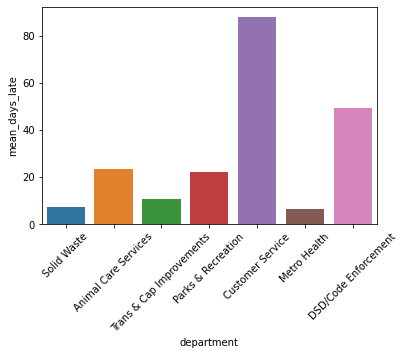

In [11]:
sns.barplot(data=answer3, x='department', y='mean_days_late')
plt.xticks(rotation=45)

## What is the service type that is the most late? Just for Parks & Rec?

In [12]:
(
df.groupBy('service_request_type')
    .agg(round(mean(df.num_days_late),2).alias('avg_days_late'))
#     .where('avg_days_late' > 0)
    .sort(col('avg_days_late').desc()).limit(10)#.desc('avg_days_late')
    .show()
)



+--------------------+-------------+
|service_request_type|avg_days_late|
+--------------------+-------------+
|  Zoning: Junk Yards|       175.96|
|Labeling for Used...|       162.43|
|Record Keeping of...|        154.0|
|Signage Requied f...|       151.64|
|Storage of Used M...|       142.11|
|Zoning: Recycle Yard|       135.93|
|Donation Containe...|       131.76|
|License Requied U...|        128.8|
|Traffic Signal Gr...|         77.9|
|           Complaint|        72.52|
+--------------------+-------------+



In [13]:
# df.select('department').distinct().show()

In [14]:
(
df.filter(df['department']=='Parks & Recreation')
    .groupBy('service_request_type')
    .agg(round(mean(df.num_days_late),2).alias('avg_days_late'))
#     .where('avg_days_late' > 0)
    .sort(col('avg_days_late').desc()).limit(10)#.desc('avg_days_late')
    .show()
)

# you can verify that sql query you did above in this exercise by removing the limit and doing a count()


+--------------------+-------------+
|service_request_type|avg_days_late|
+--------------------+-------------+
|Reservation Assis...|        66.03|
|Park Building Mai...|        24.32|
| Sportfield Lighting|        19.38|
|          Electrical|        11.75|
|Amenity Park Impr...|        10.11|
|        Tree Removal|         5.66|
|            Painting|         4.35|
|Tree Trimming/Mai...|         4.24|
|General Building ...|         4.19|
|             Masonry|         4.18|
+--------------------+-------------+



In [15]:
answer4a = (
df.groupBy('service_request_type')
    .agg(round(mean(df.num_days_late),2).alias('avg_days_late'))
#     .where('avg_days_late' > 0)
    .sort(col('avg_days_late').desc()).limit(10)#.desc('avg_days_late')
    .toPandas()
)

answer4b = (
df.filter(df['department']=='Parks & Recreation')
    .groupBy(col('service_request_type').alias('P&R_svc_rqst_type'))
    .agg(round(mean(df.num_days_late),2).alias('avg_days_late'))
#     .where('avg_days_late' > 0)
    .sort(col('avg_days_late').desc()).limit(10)#.desc('avg_days_late')
    .toPandas()
)

In [16]:
answer4b

,P&R_svc_rqst_type,avg_days_late
0,Reservation Assistance,66.03
1,Park Building Maint Invest,24.32
2,Sportfield Lighting,19.38
3,Electrical,11.75
4,Amenity Park Improvement,10.11
5,Tree Removal,5.66
6,Painting,4.35
7,Tree Trimming/Maintenance,4.24
8,General Building Maintenance,4.19
9,Masonry,4.18


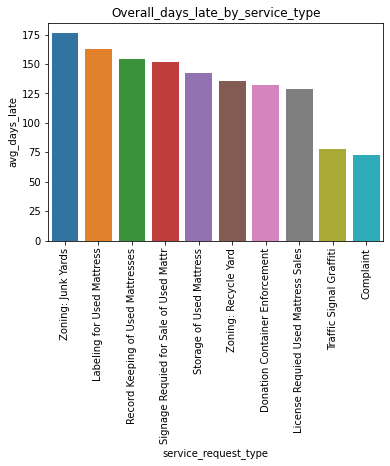

In [17]:
sns.barplot(data=answer4a, x='service_request_type', y='avg_days_late')
plt.title('Overall_days_late_by_service_type')
plt.xticks(rotation=90);

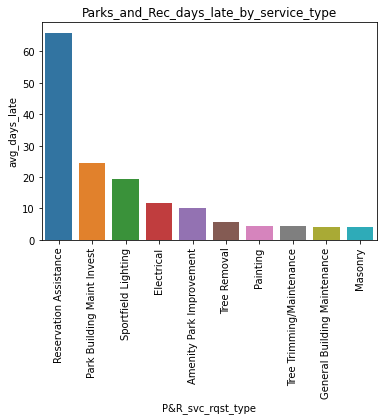

In [18]:
sns.barplot(data=answer4b, x='P&R_svc_rqst_type', y='avg_days_late')
plt.title('Parks_and_Rec_days_late_by_service_type')
plt.xticks(rotation=90);

## For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.

In [19]:
# df.select('department').distinct().show()
# df.columns

In [20]:
dept_list = df.select('department').distinct().collect()

In [21]:
import re
dept_list = ['Solid Waste',
 'Animal Care Services',
 'Trans & Cap Improvements',
 'Parks & Recreation',
 'Customer Service',
 'Metro Health',
 'City Council',
 'DSD/Code Enforcement']

In [22]:
dept_list[0]

'Solid Waste'

In [23]:
# Regex fail:
# re.search(r"^\'.*\'$",dept_list[0])

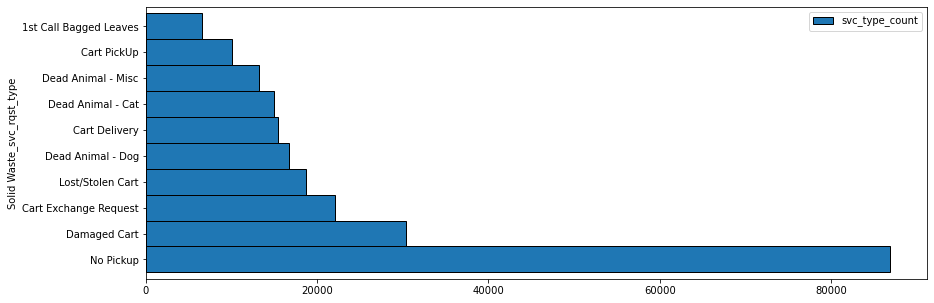

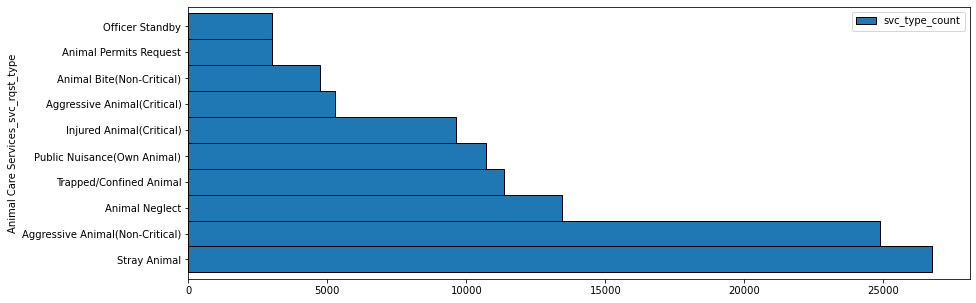

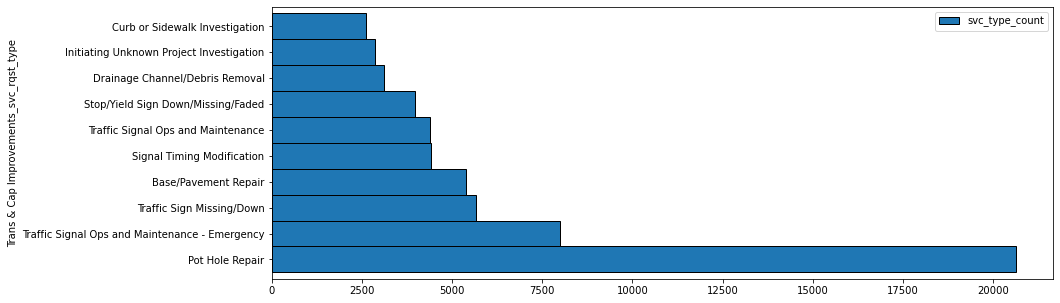

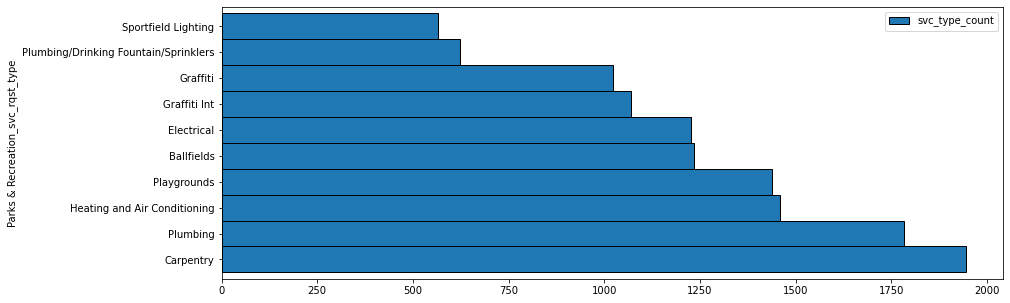

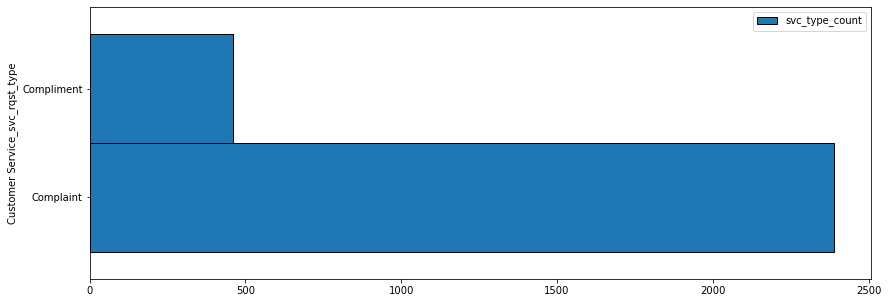

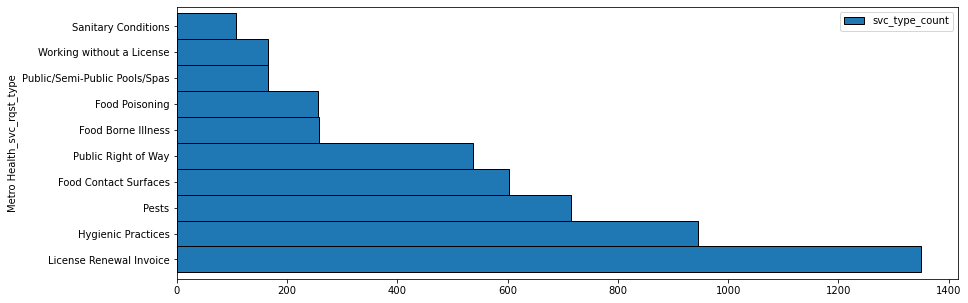

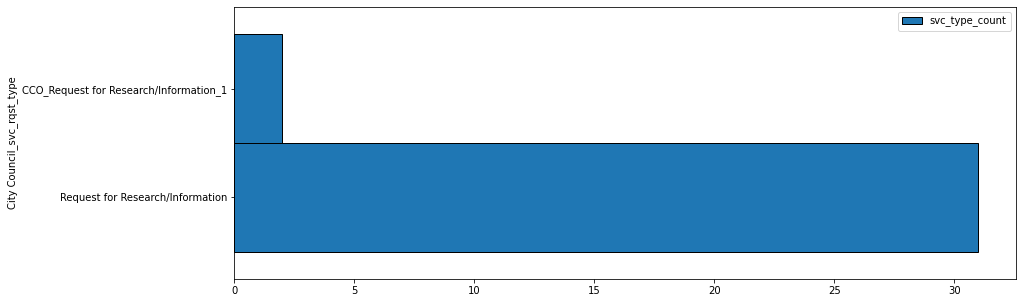

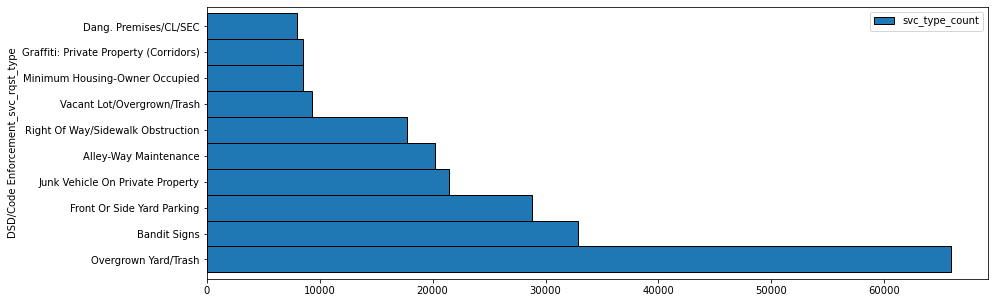

In [24]:
########################################################################
######## This code gets you the answer for DSD/Code Enforcement alone
########################################################################

# (
# df.filter(col('department')=='DSD/Code Enforcement')
#     .groupBy('service_request_type')
#     .agg(count(col('service_request_type')).alias('svc_type_count'))
#     .sort(col('svc_type_count').desc()).limit(10)
#     .show()
# )


########################################################################
######## Shooting for a for loop here...and it works : )
########################################################################
# for dept in dept_list:    
#         (
#         df.filter(col('department')== dept)
#         .groupBy(col('service_request_type').alias(f'{dept}_svc_rqst_type'))
#         .agg(count(col('service_request_type')).alias('svc_type_count'))
#         .sort(col('svc_type_count').desc()).limit(10)
#         .show()
#     )

for dept in dept_list:    
        (
        df.filter(col('department')== dept)
        .groupBy(col('service_request_type').alias(f'{dept}_svc_rqst_type'))
        .agg(count(col('service_request_type')).alias('svc_type_count'))
        .sort(col('svc_type_count').desc()).limit(10)
        .toPandas()
        .set_index(f'{dept}_svc_rqst_type')
        .plot.barh(width=1, edgecolor="black", figsize=(14, 5))
    )
        
        
########################################################################
######## Excellent code, pat on the back
########################################################################

## Does whether or not its a weekend matter for when a case is opened/closed?

- Ravinder has a nice way to order this sunday-saturday

In [25]:
df.select(date_format(col('case_opened_date'),'E')).show(3)
# check out that date_format function, with datetime patterns available

+--------------------------------+
|date_format(case_opened_date, E)|
+--------------------------------+
|                             Mon|
|                             Mon|
|                             Mon|
+--------------------------------+
only showing top 3 rows



In [34]:
df = df.withColumn('day_of_week_opened', date_format(col('case_opened_date'),'E')).withColumn('day_of_week_closed', date_format(col('case_closed_date'),'E'))
# integer data types

In [35]:
df.dtypes

[('case_id', 'int'),
 ('case_opened_date', 'timestamp'),
 ('case_closed_date', 'timestamp'),
 ('case_due_date', 'timestamp'),
 ('case_late', 'boolean'),
 ('num_days_late', 'double'),
 ('case_closed', 'boolean'),
 ('service_request_type', 'string'),
 ('SLA_days', 'double'),
 ('case_status', 'string'),
 ('source_id', 'string'),
 ('request_address', 'string'),
 ('council_district', 'string'),
 ('num_weeks_late', 'double'),
 ('zipcode', 'string'),
 ('case_age', 'int'),
 ('days_to_closed', 'int'),
 ('case_lifetime', 'int'),
 ('department', 'string'),
 ('dept_subject_to_SLA', 'boolean'),
 ('day_of_week_opened', 'string'),
 ('day_of_week_closed', 'string')]

In [28]:
# test.show(1, vertical=True)

In [36]:
(
df.groupBy('day_of_week_opened')
    .count()
    .show()
)

+------------------+------+
|day_of_week_opened| count|
+------------------+------+
|               Sun| 28765|
|               Mon|153104|
|               Thu|153724|
|               Sat| 53678|
|               Wed|147213|
|               Tue|161624|
|               Fri|143596|
+------------------+------+



In [37]:
(
df.groupBy('day_of_week_closed')
    .count()
    .show()
)

+------------------+------+
|day_of_week_closed| count|
+------------------+------+
|               Sun| 26867|
|              null| 18110|
|               Mon|135069|
|               Thu|145725|
|               Sat| 61160|
|               Wed|170715|
|               Tue|154916|
|               Fri|129142|
+------------------+------+



In [45]:
opened = (
df.groupBy('day_of_week_opened')
    .count()
    .toPandas().set_index('day_of_week_opened')
)
closed =(
df.groupBy('day_of_week_closed')
    .count()
    .toPandas().set_index('day_of_week_closed')
)

In [49]:
opened

,count
day_of_week_opened,
Sun,28765
Mon,153104
Thu,153724
Sat,53678
Wed,147213
Tue,161624
Fri,143596


<AxesSubplot:xlabel='day_of_week_closed', ylabel='count'>

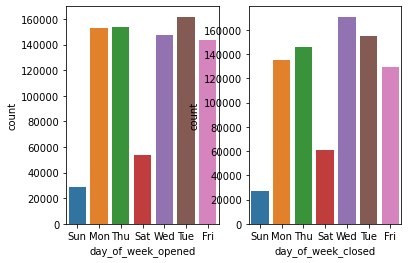

In [52]:
f, axes = plt.subplots(1, 2)
sns.barplot(  y="count", x= opened.index, data=opened,  orient='v' , ax=axes[0])
sns.barplot(  y="count", x= closed.index, data=closed,  orient='v' , ax=axes[1])

## On average, how many cases are opened a day for the Customer Service department?

## Does the number of service requests for the solid waste department vary by day of the week?